## Introduction

The purpose of this .ipynb is to reprduce BPNet paper plot of Odds ratio with TSC factors model (same as BPNet paper fig4d)

## Computational setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Packages
import os
import sys
import pandas as pd
import numpy as np
from pybedtools import BedTool
from tqdm import tqdm
from bpnet.cli.contrib import bpnet_contrib
from bpnet.cli.modisco import cwm_scan
from bpnet.cli.contrib import ContribFile
from bpnet.BPNet import BPNetSeqModel
from concise.preprocessing import encodeDNA
from bpnet.simulate import random_seq, insert_motif
from bpnet.plot.tracks import plot_tracks, to_neg
from collections import OrderedDict

os.chdir(f'/n/projects/kd2200/publication/bpnet/analysis/')
pd.set_option('display.max_columns', 100)

# Custom commands
sys.path.insert(0, f'/n/projects/kd2200/publication/bpnet/analysis/scripts/bpnet/scripts')
from data_format_functions import myround, myfloor, myceiling, df_to_intervals,tidy_bpnet_predictions_nexus, one_hot_decode
from motif_functions import remove_palindromic_motif_duplicates, filter_overlapping_motifs_by_priority

# function to return key for any value 
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
        if val == value: 
            return key 
    return "key doesn't exist"

#Function to save contribution information with 4 columns and a task (does not use hypoth. contrib)
def tidy_bpnet_contributions(seq, contrib, tasks, contrib_type = 'profile'):
    contrib_df = pd.DataFrame()
    for task in tasks:
        c = contrib[f'{task}/{contrib_type}'] * seq
        df = pd.DataFrame(c, columns = ['A','C','G','T'])
        df['task'] = task
        contrib_df=contrib_df.append(df)
    return(contrib_df)

Using TensorFlow backend.


2023-12-17 01:13:04,382 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

2023-12-17 01:13:07,215 [INFO] Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-12-17 01:13:07,217 [INFO] Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-17 01:13:07,218 [INFO] NumExpr defaulting to 8 threads.


In [2]:
# Pre-existing variables
fasta_file = f'/n/projects/kd2200/publication/bpnet/fasta/mm10.fa'
model_dir = f'/n/projects/kd2200/publication/bpnet/model/dataspec.yaml_default_fold_5/'
modisco_dir = f'/n/projects/kd2200/publication/bpnet/modisco/profile/dataspec.yaml_default_fold_5/'
cwm_scan_all_dir = f'/n/projects/kd2200/publication/bpnet/cwm_all_regions/'
cwm_scan_task_dir = f'/n/projects/kd2200/publication/bpnet/cwm_task_regions/'
tasks = ['tead4','tfap2c','yap1','gata3','cdx2']

In [3]:
from bpnet.BPNet import BPNetSeqModel
tsc_bpnet = BPNetSeqModel.from_mdir(model_dir)

2023-12-17 01:13:13,906 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2023-12-17 01:13:13,941 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2023-12-17 01:13:14,569 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2023-12-17 01:13:14,572 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2023-12-17 01:13:14,574 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2023-12-17 01:13:14,623 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2023-12-17 01:13:14,625 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2023-12-17 01:13:14,788 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



2023-12-17 01:13:14,982 [WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



2023-12-17 01:13:15,919 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2023-12-17 01:13:16,213 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [19]:
##motifs of interrst

motifs_of_interest_dict = {'tead4': 'tead4/m0_p0',
                           'tead4_double': 'tead4/m0_p1',
                           'tfap2c': 'tfap2c/m0_p0',
                           'cdx2':'cdx2/m0_p0',
                           'gata3':'gata3/m0_p4',
                            'gata3_double':'gata3/m0_p1',
                            'junfos':'tead4/m0_p7',
                           'elf5':'yap1/m0_p6'}

#motifs of interrst from Yap1 task

# motifs_of_interest_dict = {'tead4': 'yap1/m0_p0',
#                            'tead4_double': 'yap1/m0_p1',
#                            'tfap2c': 'yap1/m0_p2',
#                            'cdx2':'yap1/m0_p11',
#                            'junfos':'yap1/m0_p3',
#                             'elf5':'yap1/m0_p6'}

In [20]:
# Imports
from bpnet.plot.heatmaps import heatmap_stranded_profile, multiple_heatmap_stranded_profile
from bpnet.plot.profiles import plot_stranded_profile, multiple_plot_stranded_profile, extract_signal
from bpnet.plot.tracks import plot_tracks, filter_tracks
from bpnet.modisco.pattern_instances import (multiple_load_instances, load_instances, filter_nonoverlapping_intervals, 
                                                plot_coocurence_matrix, align_instance_center, dfi2seqlets, annotate_profile,get_motif_pairs, motif_pair_dfi)

from bpnet.preproc import rc_seq, dfint_no_intersection
from copy import deepcopy
from scipy.fftpack import fft, ifft
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#paper_config()

# interval columns in dfi
interval_cols = ['example_chrom', 'pattern_start_abs', 'pattern_end_abs']

In [21]:
# Generate motif pairs
pairs = get_motif_pairs(motifs_of_interest_dict.keys())

# ordered names
pair_names = ["<>".join(x) for x in pairs]

In [22]:
pair_names

['tead4<>tead4',
 'tead4<>tead4_double',
 'tead4<>tfap2c',
 'tead4<>cdx2',
 'tead4<>gata3',
 'tead4<>gata3_double',
 'tead4<>junfos',
 'tead4<>elf5',
 'tead4_double<>tead4_double',
 'tead4_double<>tfap2c',
 'tead4_double<>cdx2',
 'tead4_double<>gata3',
 'tead4_double<>gata3_double',
 'tead4_double<>junfos',
 'tead4_double<>elf5',
 'tfap2c<>tfap2c',
 'tfap2c<>cdx2',
 'tfap2c<>gata3',
 'tfap2c<>gata3_double',
 'tfap2c<>junfos',
 'tfap2c<>elf5',
 'cdx2<>cdx2',
 'cdx2<>gata3',
 'cdx2<>gata3_double',
 'cdx2<>junfos',
 'cdx2<>elf5',
 'gata3<>gata3',
 'gata3<>gata3_double',
 'gata3<>junfos',
 'gata3<>elf5',
 'gata3_double<>gata3_double',
 'gata3_double<>junfos',
 'gata3_double<>elf5',
 'junfos<>junfos',
 'junfos<>elf5',
 'elf5<>elf5']

In [23]:
# define the global set of distances
dist_subsets = ['center_diff<=35',
               '(center_diff>35)&(center_diff<=70)', 
               '(center_diff>70)&(center_diff<=150)', 
               'center_diff>150']
dist_subset_labels = ['dist < 35',
                      '35 < dist <= 70',
                      '70 < dist <= 150',
                      '150 > dist',
                     ]

In [24]:
# getting all the regions
cwm_scan_regions_df = pd.DataFrame()

for task in tasks:
    df = pd.read_csv(f'{cwm_scan_all_dir}/{task}/instances_by_pattern/motif-instances-all-regions.tsv.gz', sep = '\t')
    cwm_scan_regions_df = cwm_scan_regions_df.append(df, sort = False)
    cwm_scan_regions_df['pattern_id'] = cwm_scan_regions_df.contrib_max_task + '/' + cwm_scan_regions_df.pattern_short
    
# Filter CWM-scanned regions based on selected motifs
cwm_scan_regions_df = cwm_scan_regions_df[cwm_scan_regions_df['pattern_id'].isin(list(motifs_of_interest_dict.values()))]
  
# Assign pattern names
cwm_scan_regions_df['pattern_name'] = [get_key(pattern_id, motifs_of_interest_dict) for pattern_id in cwm_scan_regions_df['pattern_id']]

# Assign row_idx associated with this particular dfi. Will allow later classes to keep track of mutations.
cwm_scan_regions_df['row_idx'] = range(cwm_scan_regions_df.shape[0])
    
cwm_scan_regions_df.shape

(490926, 41)

In [25]:
cwm_scan_regions_df['row_idx'] = np.arange(len(cwm_scan_regions_df))
cwm_scan_regions_df['Chromosome'] = cwm_scan_regions_df.example_chrom
cwm_scan_regions_df['Start'] = cwm_scan_regions_df.pattern_start_abs
cwm_scan_regions_df['End'] = cwm_scan_regions_df.pattern_end_abs
cwm_scan_regions_df

,example_chrom,pattern_start_abs,pattern_end_abs,pattern,contrib_weighted_p,strand,match_weighted_p,example_idx,pattern_start,pattern_end,pattern_center,pattern_len,match_weighted,match_weighted_cat,match_max,match_max_task,contrib_weighted,contrib_weighted_cat,contrib_max,contrib_max_task,seq_match,seq_match_p,seq_match_cat,match/tead4,contrib/tead4,pattern_short,example_start,example_end,example_strand,example_interval_from_task,pattern_id,match/tfap2c,contrib/tfap2c,match/yap1,contrib/yap1,match/gata3,contrib/gata3,match/cdx2,contrib/cdx2,pattern_name,row_idx,Chromosome,Start,End
0,chr1,186294923,186294932,metacluster_0/pattern_0,0.223602,+,0.223602,0,583,592,588,9,0.637341,low,0.637341,tead4,1.111870,low,1.111870,tead4,3.445102,0.014161,low,0.637341,1.111870,m0_p0,186294340,186295340,.,cdx2,tead4/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tead4,0,chr1,186294923,186294932
1,chr1,60181093,60181102,metacluster_0/pattern_0,0.389565,+,0.434161,1,542,551,547,9,0.695779,medium,0.695779,tead4,1.549856,medium,1.549856,tead4,8.573500,0.470062,medium,0.695779,1.549856,m0_p0,60180551,60181551,.,cdx2,tead4/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tead4,1,chr1,60181093,60181102
2,chr1,60181142,60181151,metacluster_0/pattern_0,0.757391,-,0.293540,1,591,600,595,9,0.660220,low,0.660220,tead4,2.723705,high,2.723705,tead4,6.550070,0.156025,low,0.660220,2.723705,m0_p0,60180551,60181551,.,cdx2,tead4/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tead4,2,chr1,60181142,60181151
3,chr1,138571399,138571408,metacluster_0/pattern_0,0.010435,-,0.490683,2,220,229,224,9,0.707038,medium,0.707038,tead4,0.614146,low,0.614146,tead4,9.816225,0.839503,high,0.707038,0.614146,m0_p0,138571179,138572179,.,cdx2,tead4/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tead4,3,chr1,138571399,138571408
4,chr1,138571723,138571732,metacluster_0/pattern_0,0.015280,-,0.385093,2,544,553,548,9,0.684980,medium,0.684980,tead4,0.642329,low,0.642329,tead4,7.533008,0.320124,low,0.684980,0.642329,m0_p0,138571179,138572179,.,cdx2,tead4/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tead4,4,chr1,138571723,138571732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68008,chrX,57379011,57379021,metacluster_0/pattern_0,0.312734,+,0.455021,187766,629,639,634,10,0.559054,medium,0.559054,cdx2,0.325481,low,0.325481,cdx2,6.449820,0.280090,low,NaN,NaN,m0_p0,57378382,57379382,.,gata3,cdx2/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,0.559054,0.325481,cdx2,490921,chrX,57379011,57379021
68009,chrX,151148636,151148646,metacluster_0/pattern_0,0.745577,+,0.604037,187767,111,121,116,10,0.590084,medium,0.590084,cdx2,0.546211,high,0.546211,cdx2,6.780375,0.357837,medium,NaN,NaN,m0_p0,151148525,151149525,.,gata3,cdx2/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,0.590084,0.546211,cdx2,490922,chrX,151148636,151148646
68010,chrX,9160419,9160429,metacluster_0/pattern_0,0.706205,-,0.290556,187769,732,742,737,10,0.519403,low,0.519403,cdx2,0.516379,high,0.516379,cdx2,6.246191,0.242711,low,NaN,NaN,m0_p0,9159687,9160687,.,gata3,cdx2/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,0.519403,0.516379,cdx2,490923,chrX,9160419,9160429
68011,chrX,98190425,98190435,metacluster_0/pattern_0,0.564665,-,0.777722,187770,820,830,825,10,0.628719,high,0.628719,cdx2,0.431636,medium,0.431636,cdx2,7.867030,0.604286,medium,NaN,NaN,m0_p0,98189605,98190605,.,gata3,cdx2/m0_p0,NaN,NaN,NaN,NaN,NaN,NaN,0.628719,0.431636,cdx2,490924,chrX,98190425,98190435


In [ ]:
%%script false --no-raise-error
!pip install pyranges #if installed then it will run it on server

In [26]:
import pyranges as pr
cwm_scan_regions_pr = pr.PyRanges(cwm_scan_regions_df)
len(cwm_scan_regions_pr)

490926

# Get repeat masker annotation and remove ERVs from dataframe


In [27]:
#functions

def read_repeat_masker(file_path):
    dfrm = pd.read_table(file_path, delim_whitespace=True, header=[1])

    dfrm.columns = [x.replace("\n", "_") for x in dfrm.columns]

    dfrm['name'] = dfrm['repeat'] + "//" + dfrm['class/family']

    dfrm = dfrm[['ins.', 'sequence', 'begin', 'name']]
    dfrm.columns = ['chrom', 'start', 'end', 'name']
    return dfrm


def intersect_repeat_masker(pattern_name, seqlets: BedTool, repeat_masker: BedTool, f=1.0):
    """Intersect the seqlets bed file with 
    """
    try:
        dfint = seqlets.intersect(repeat_masker, wa=True, wb=True, f=f).to_dataframe()
    except Exception:
        return None
    t = dfint.blockCount.str.split("//", expand=True)
    dfint['pattern_name'] = pattern_name
    dfint['repeat_name'] = t[0]
    dfint['repeat_family'] = t[1]
    dfint['n_pattern'] = seqlets.to_dataframe()[['chrom', 'start', 'end']].drop_duplicates().shape[0]
    dfint['interval'] = dfint['chrom'] + ":" + dfint['start'].astype(str) + "-" + dfint['end'].astype(str)
    return dfint[['chrom', 'start', 'end', 'interval', 'pattern_name', 'n_pattern', 'repeat_name', 'repeat_family']]

In [28]:
# load repeat masker file and remove ervs
rm_filepath = f'/n/projects/kd2200/publication/bpnet/analysis/data/repeatmasker.mm10.fa.out.gz'
dfrm = read_repeat_masker(rm_filepath)
dfrm_erv = dfrm[dfrm.name.str.contains("ERV")]
dfrm_erv['Start'] = dfrm_erv['start']
dfrm_erv['End'] = dfrm_erv['end']
dfrm_erv['Chromosome'] = dfrm_erv['chrom']
dfrm_erv = pr.PyRanges(dfrm_erv)

# exclude erv's
exclude = cwm_scan_regions_pr.overlap(dfrm_erv).df.row_idx.unique()
exclude_rows = cwm_scan_regions_df.row_idx.isin(exclude)
print(exclude_rows.value_counts())
print(f"Excluding: {len(exclude)} / {len(cwm_scan_regions_df)} rows")
cwm_scan_regions_df['is_erv'] = exclude_rows #.astype(str)

#check motif counts without ERVs
dfi = cwm_scan_regions_df[(cwm_scan_regions_df['is_erv'].astype(str)=='False')]
dfi.is_erv.value_counts()

False    423176
True      67750
Name: row_idx, dtype: int64
Excluding: 67750 / 490926 rows


False    423176
Name: is_erv, dtype: int64

# Create motif pairs

In [29]:
# create motif pairs
dfab = pd.concat([motif_pair_dfi(dfi[(~dfi.is_erv)], pair).assign(motif_pair="<>".join(pair)) for pair in pairs], axis=0)

In [30]:
# Remove self matches
dfab = dfab.query('~((pattern_center_x == pattern_center_y) & (strand_x == strand_y))')

In [31]:
def co_occurence_matrix(dfi_subset, query_string=""):
    """Returns the fraction of times pattern x (row) overlaps pattern y (column)
    """
    from bpnet.stats import norm_matrix
    total_number = dfi_subset.groupby(['pattern']).size()
    norm_counts = norm_matrix(total_number)

    # normalization: minimum number of counts
    total_number = dfi_subset.groupby(['pattern_name']).size()
    norm_counts = norm_matrix(total_number)

    # cross-product
    dfi_filt_crossp = pd.merge(dfi_subset[['pattern_name', 'pattern_center',
                                           'strand', 'example_idx']].set_index('example_idx'),
                               dfi_subset[['pattern_name', 'pattern_center',
                                           'strand', 'example_idx']].set_index('example_idx'),
                               how='outer', left_index=True, right_index=True).reset_index()
    # remove self-matches
    dfi_filt_crossp = dfi_filt_crossp.query('~((pattern_name_x == pattern_name_y) & '
                                            '(pattern_center_x == pattern_center_y) & '
                                            '(strand_x == strand_y))')
    dfi_filt_crossp['center_diff'] = dfi_filt_crossp.eval("abs(pattern_center_x- pattern_center_y)")
   

    if query_string:
        dfi_filt_crossp = dfi_filt_crossp.query(query_string)
    match_sizes = dfi_filt_crossp.groupby(['pattern_name_x', 'pattern_name_y']).size()
    count_matrix = match_sizes.unstack(fill_value=0)

    norm_count_matrix = count_matrix / norm_counts  # .truediv(min_counts, axis='columns').truediv(total_number, axis='index')
    norm_count_matrix = norm_count_matrix.fillna(0)  # these examples didn't have any paired pattern
    
    return count_matrix, norm_count_matrix, norm_counts


def chi2_test_coc(random_coocurrence_counts, random_coocurrence,
                    random_coocurrence_norm, coocurrence_counts, coocurrence, coocurrence_norm):
    from scipy.stats import chi2_contingency
    cols = list(coocurrence_norm.columns)
    n = len(random_coocurrence_counts)
    o = np.zeros((n, n))
    op = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            
            # [[# not randomly found together , # not found together],
            #  [# randomly found together     , # found together]]
            ct = [[random_coocurrence_norm.iloc[i, j] - random_coocurrence_counts.iloc[i, j],
                   coocurrence_norm.iloc[i, j] - coocurrence_counts.iloc[i, j]],
                  [random_coocurrence_counts.iloc[i, j],
                   coocurrence_counts.iloc[i, j]]]
            ct = np.array(ct)
            # TODO - make this an actual fisher exact test from
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
            # or the chi-square contingency table:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency
            chi2, p, dof, ex = chi2_contingency(ct, correction=False)
            # t22 = sm.stats.contingency_tables.Table2x2(np.array(ct))
            
            o[i, j] = (ct[1, 1] / ct[0, 1]) / (ct[1, 0] / ct[0, 0 ])
            op[i, j] = p
    return pd.DataFrame(o, columns=cols, index=cols), pd.DataFrame(op, columns=cols, index=cols)


def coocurrence_plot(dfi_subset, motif_list, query_string="(abs(pattern_center_x- pattern_center_y) <= 150)",
                     signif_threshold=1e-5, ax=None, **kwargs):
    """Test for co-occurence

    Args:
      dfi_subset: desired subset of dfi
      motif_list: list of motifs used to order the heatmap
      query_string: string used with df_cross.query() to detering the valid motif pairs
      signif_threshold: significance threshold for Fisher's exact test
    """
    import seaborn as sns
    if ax is None:
        ax = plt.gca()
    c_counts, c, c_norm = co_occurence_matrix(dfi_subset, query_string=query_string)

    # Generate the NULL
    dfi_subset_random = dfi_subset.copy()
    np.random.seed(42)
    # TODO - shall we draw the sample indices completely at random?
    dfi_subset_random['example_idx'] = dfi_subset_random['example_idx'].sample(frac=1).values
    rc_counts, rc, rc_norm = co_occurence_matrix(dfi_subset_random, query_string=query_string)

    # test for significance
    o, op = chi2_test_coc(rc_counts, rc, rc_norm, c_counts, c, c_norm)

    # re-order
    o = o[motif_list].loc[motif_list]
    op = op[motif_list].loc[motif_list]

    signif = op < signif_threshold
    a = np.zeros_like(signif).astype(str)
    a[signif] = "*"
    a[~signif] = ""
    sns.heatmap(o, annot=a, fmt="", vmin=0, vmax=2,
                cmap='RdBu_r', ax=ax, **kwargs)
    ax.set_title(f"odds-ratio (proximal / non-proximal) (*: p<{signif_threshold})")
    return o,op

# Plot all distance ranges for all combination

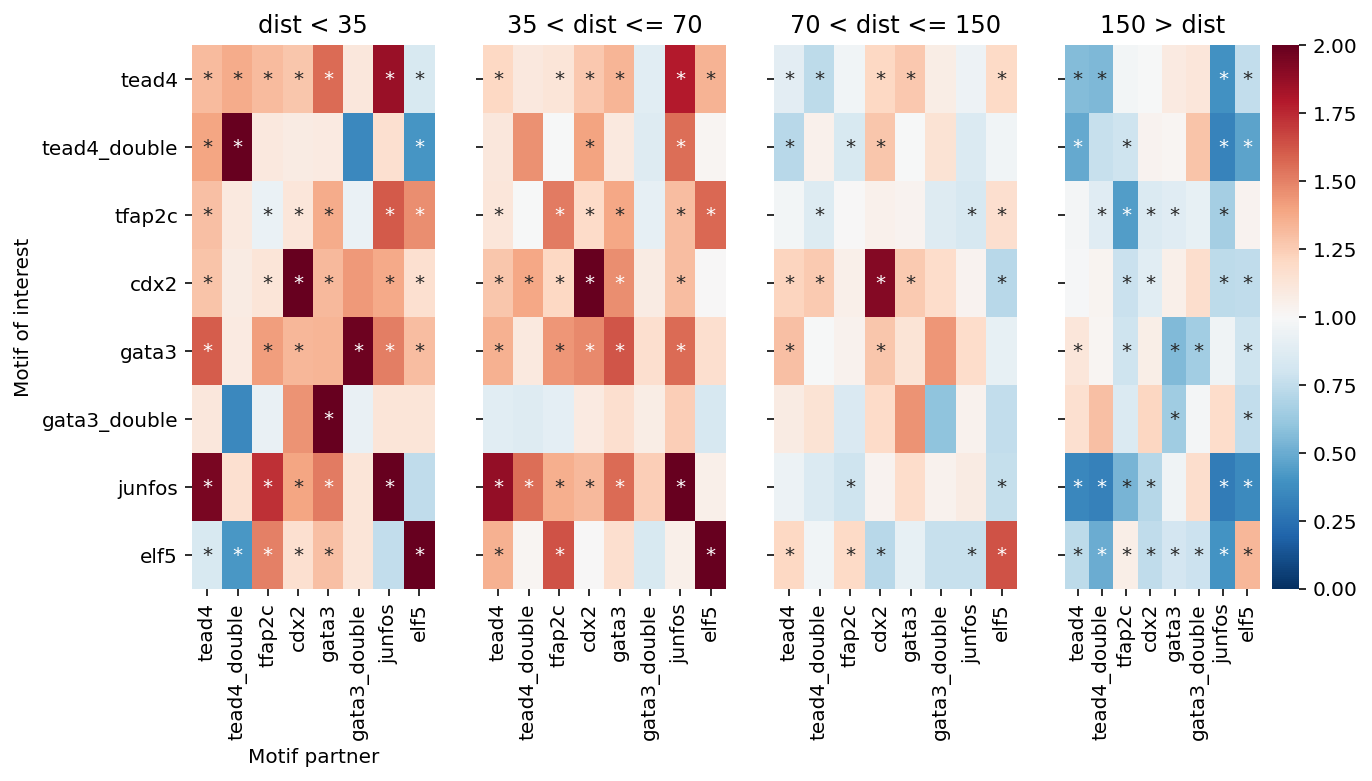

In [32]:
import matplotlib.pyplot as plt
subsets = dist_subsets
fig,axes = plt.subplots(1, len(subsets), 
                        figsize=(10,5), 
                        sharey=True)
dfs = dfi[(~dfi.is_erv)]
for i, (subset,ax, subset_label) in enumerate(zip(subsets, axes, dist_subset_labels)):
    if i == len(subsets) - 1:
        cbar = True
    else:
        cbar = False
    x=coocurrence_plot(dfs, list(motifs_of_interest_dict.keys()), query_string=f"({subset}) & (center_diff > 5)" , ax=ax, cbar=cbar)
    #print(x)
    if i == 0:
        ax.set_ylabel("Motif of interest")
        ax.set_xlabel("Motif partner");
    
    ax.set_title(subset_label)

In [33]:
# plot
fig.savefig('figures/6_odds_ratio/all_coocurrence_2.all-dist_withthreshold.main-motifs.pdf')
#fig.savefig('figures/6_odds_ratio/all_coocurrence_from_yap1_task_2.all-dist_withthreshold.main-motifs.pdf')